In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
# Fixed seed: report this value
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# CIFAR-10 normalization stats
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

# Baseline transforms (no augmentation)
train_transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# Augmented transforms: used only in the "constrained modification" experiment
train_transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# Test/validation transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])


In [ ]:
def get_cifar10_loaders(batch_size=128, use_augmentation=False, val_size=5000):
    transform_train = train_transform_aug if use_augmentation else train_transform_baseline

    full_train = datasets.CIFAR10(root="./data", train=True, download=True,
                                  transform=transform_train)
    subset_size = 25000
    full_train, _ = random_split(full_train, [subset_size, len(full_train) - subset_size], generator=torch.Generator().manual_seed(SEED))

    test_set = datasets.CIFAR10(root="./data", train=False, download=True,
                                transform=test_transform)

    train_size = len(full_train) - val_size
    train_set, val_set = random_split(full_train, [train_size, val_size],
                                      generator=torch.Generator().manual_seed(SEED))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [ ]:
def get_resnet18_cifar10():
    model = models.resnet18(weights=None)  # no pretrained weights
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def run_experiment(use_augmentation=False, num_epochs=20, lr=0.1):
    train_loader, val_loader, test_loader = get_cifar10_loaders(
        batch_size=128,
        use_augmentation=use_augmentation
    )

    model = get_resnet18_cifar10().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Final test accuracy
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    return model, (train_loader, val_loader, test_loader), history


In [ ]:
# Baseline (no augmentation)
baseline_model, baseline_loaders, baseline_hist = run_experiment(
    use_augmentation=False, num_epochs=40, lr=0.1
)

# Constrained modification (with augmentation)
aug_model, aug_loaders, aug_hist = run_experiment(
    use_augmentation=True, num_epochs=40, lr=0.1
)

Epoch 1/40 Train Loss: 2.4057 Acc: 0.2953 Val Loss: 2.0627 Acc: 0.3786
Epoch 2/40 Train Loss: 1.6115 Acc: 0.4239 Val Loss: 1.7415 Acc: 0.4236
Epoch 3/40 Train Loss: 1.3904 Acc: 0.4965 Val Loss: 1.4196 Acc: 0.4810
Epoch 4/40 Train Loss: 1.2432 Acc: 0.5546 Val Loss: 1.2564 Acc: 0.5574
Epoch 5/40 Train Loss: 1.1181 Acc: 0.5990 Val Loss: 1.1660 Acc: 0.5836
Epoch 6/40 Train Loss: 1.0042 Acc: 0.6459 Val Loss: 1.1680 Acc: 0.5880
Epoch 7/40 Train Loss: 0.9100 Acc: 0.6780 Val Loss: 1.1261 Acc: 0.6012
Epoch 8/40 Train Loss: 0.8047 Acc: 0.7154 Val Loss: 1.0403 Acc: 0.6338
Epoch 9/40 Train Loss: 0.7303 Acc: 0.7427 Val Loss: 1.1251 Acc: 0.6274
Epoch 10/40 Train Loss: 0.6584 Acc: 0.7700 Val Loss: 1.0772 Acc: 0.6266
Epoch 11/40 Train Loss: 0.5795 Acc: 0.7968 Val Loss: 1.0654 Acc: 0.6410
Epoch 12/40 Train Loss: 0.5352 Acc: 0.8133 Val Loss: 1.0753 Acc: 0.6504
Epoch 13/40 Train Loss: 0.4759 Acc: 0.8356 Val Loss: 1.2172 Acc: 0.6390
Epoch 14/40 Train Loss: 0.4504 Acc: 0.8447 Val Loss: 1.2179 Acc: 0.6420
E

In [ ]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def get_failure_cases(model, loader, device, max_cases=1000):
    model.eval()
    failure_cases = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probs = F.softmax(logits, dim=1)
            confs, preds = probs.max(dim=1)

            mismatches = preds.ne(labels)
            if mismatches.any():
                for i in torch.where(mismatches)[0]:
                    failure_cases.append({
                        "image": images[i].cpu(),        # normalized tensor
                        "label": labels[i].item(),
                        "pred": preds[i].item(),
                        "conf": confs[i].item(),
                        "probs": probs[i].cpu(),
                    })
            if len(failure_cases) >= max_cases:
                break

    # Sort by confidence descending
    failure_cases.sort(key=lambda x: x["conf"], reverse=True)
    return failure_cases


In [ ]:
_, _, test_loader = baseline_loaders
baseline_failures = get_failure_cases(baseline_model, test_loader, device, max_cases=500)

print(f"Collected {len(baseline_failures)} failure cases.")
for i in range(3):
    fc = baseline_failures[i]
    print(i,
          "True:", classes[fc["label"]],
          "Pred:", classes[fc["pred"]],
          f"Conf: {fc['conf']:.3f}")


Collected 506 failure cases.
0 True: ship Pred: airplane Conf: 1.000
1 True: bird Pred: dog Conf: 1.000
2 True: ship Pred: airplane Conf: 1.000


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.fwd_handle = target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, target_class=None):
        self.model.zero_grad()
        out = self.model(x)

        if target_class is None:
            target_class = out.argmax(dim=1)

        # For batch, we do class-wise gradient
        loss = out[torch.arange(x.size(0)), target_class]
        loss.backward(torch.ones_like(loss))

        grads = self.gradients  # [B, C, H, W]
        activations = self.activations  # [B, C, H, W]

        weights = grads.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        cam = (weights * activations).sum(dim=1, keepdim=True)  # [B, 1, H, W]
        cam = F.relu(cam)

        # Normalize CAM to [0,1] per image
        B, _, H, W = cam.size()
        cam = cam.view(B, -1)
        cam_min, cam_max = cam.min(dim=1, keepdim=True).values, cam.max(dim=1, keepdim=True).values
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        cam = cam.view(B, 1, H, W)

        return cam

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()


In [ ]:
# Example: create Grad-CAM object for baseline model
target_layer = baseline_model.layer4[-1].conv2
gradcam_baseline = GradCAM(baseline_model, target_layer)


In [ ]:
import numpy as np

def denormalize(img_tensor):
    # img_tensor: [3, H, W], normalized
    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def show_gradcam_on_image(img_tensor, cam_tensor, alpha=0.5):
    """
    img_tensor: [3, H, W] (normalized)
    cam_tensor: [1, Hc, Wc] (values in [0,1], upsample to H,W)
    """
    img = denormalize(img_tensor).permute(1, 2, 0).numpy()  # H,W,3
    cam = cam_tensor.squeeze(0).cpu().numpy()               # Hc,Wc

    # Resize CAM to image size
    cam = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam = F.interpolate(cam, size=img.shape[:2], mode="bilinear", align_corners=False)
    cam = cam.squeeze().numpy()

    heatmap = plt.get_cmap("jet")(cam)[:, :, :3]  # drop alpha
    overlay = alpha * heatmap + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


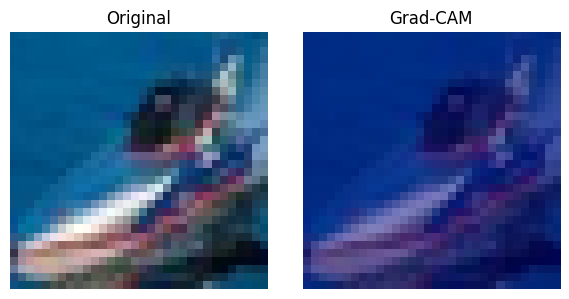

True: ship Pred: airplane Conf: 1.000


In [ ]:
# Pick one failure case from baseline_failures
fc = baseline_failures[0]
img = fc["image"].unsqueeze(0).to(device)  # [1,3,32,32]

with torch.no_grad():
    pred = baseline_model(img).argmax(dim=1).item()

cam = gradcam_baseline(img, target_class=torch.tensor([pred]).to(device))
show_gradcam_on_image(fc["image"], cam[0].cpu())

print("True:", classes[fc["label"]],
      "Pred:", classes[fc["pred"]],
      f"Conf: {fc['conf']:.3f}")


In [ ]:
target_layer_aug = aug_model.layer4[-1].conv2
gradcam_aug = GradCAM(aug_model, target_layer_aug)
